Name: Jingyue Xu

Group number: 7

# Instructions:
**To start working on this Homework Assignment, create a copy of this notebook and save it within your Google Drive (File -> Save a copy in Drive).**

This Jupyter notebook contains 3 exercises consisting of coding and discussion questions. For the discussion questions, please write your answer inside a new text cell. Please hand in your .ipynb file (File -> Download -> Download .ipynb) on canvas by 11:59pm on **May 2nd**.

To execute the code, it is necessary to load some external packages, so please execute the following code block.

While you should work in a group, please answer in the discussion sections individually.

In [52]:
# @title Install packages
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt
import itertools

from numpy import random
from scipy.integrate import odeint

# Q1

### 1.0
* Simulate the spiking activity of a presynaptic neuron, which will serve as input to a postsynaptic neuron.

The presynaptic neuron should have firing rate $r=10Hz$ (use time bins of $\Delta t=1ms$, and assume that the neuron randomly produces either one spike or no spikes in each bin).

---
Hint: Read page 30 of Theoretical Neuroscience by Dayan & Abbott.

---

In [53]:
# @title Generate Poisson spike train
fr = 10 # Firing rate = 10 Hz
dt = .001 # Time bin = 1 ms
nBins = 1000 # 1000 ms spike train
st = (random.rand(nBins) < fr*dt)*1
print('The firing rate is: ' + str(sum(st)/nBins*1000))

# @markdown references<br>
# @markdown https://praneethnamburi.com/2015/02/05/simulating-neural-spike-trains/

The firing rate is: 10.0


### 1.1
Use the Tsodyks-Markram model to simulate the synaptic resources, in two scenarios.
* Scenario 1: Short-term depression. No facilitation ($U=0.5$ is constant); $\tau_{in}=3ms$; $\tau_{rec} = 800ms$.
* Scenario 2: Short-term facilitation and depression. $U_1=0.03$; $\tau_{facil} = 530ms$; $\tau_{in}=1.5ms$; $\tau_{rec} = 130ms$.

Plot the input spike train and the state variables of the synapse as a function of time (x, y, z in Scenario 1; x, y, z, U in Scenario 2).

---
Reminder:

$$
\begin{aligned}
\frac{\mathrm{d} x}{\mathrm{~d} t} &=\frac{z}{\tau_{\text {rec }}}-U x \delta\left(t-t_{i}\right) \\
\frac{\mathrm{d} y}{\mathrm{~d} t} &=-\frac{y}{\tau_{\text {in }}}+U x \delta\left(t-t_{i}\right) \\
\frac{\mathrm{d} z}{\mathrm{~d} t} &=\frac{y}{\tau_{\text {in }}}-\frac{z}{\tau_{\text {rec }}} \\
\frac{\mathrm{d} U}{\mathrm{~d} t} &=-\frac{U}{\tau_{\text {facil }}}+U_{1}(1-U) \delta\left(t-t_{i}\right)
\end{aligned}
$$



Text(0.5, 0, 'Time (s)')

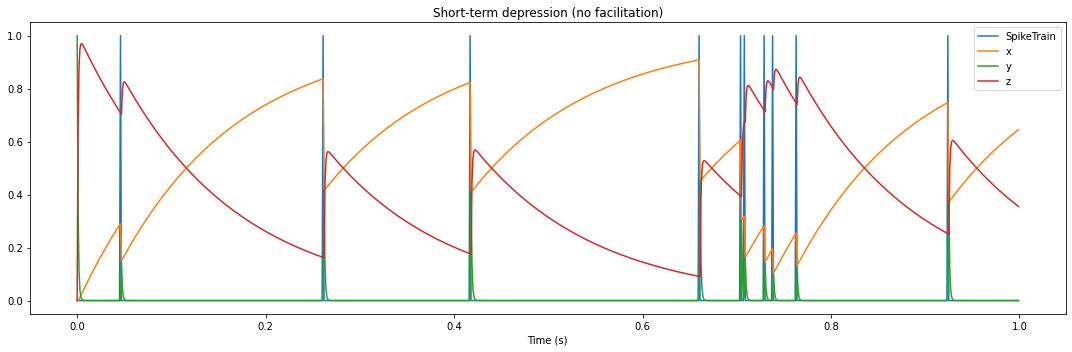

In [54]:
# Scenario 1
"""Initialize constants"""
U = 0.5
tau_in = 3
tau_rec = 800

U1 = 0.03
tau_facil = 530
tau_in = 1.5
tau_rec = 130

x, y, z = [[0]*1000, [1]*1000, [0]*1000]
t = np.arange(0,1,0.001)

# Loop over simulation time
for i in range(len(t)-1):
  x[i+1] = x[i] + z[i]/tau_rec - U*x[i]*st[i]
  y[i+1] = y[i] + -y[i]/tau_in + U*x[i]*st[i]
  z[i+1] = z[i] + y[i]/tau_in - z[i]/tau_rec

# Plot spike train, x, y, and z
fig1 = plt.figure(1, figsize = (15, 5), tight_layout = True)
plt.plot(t, st, label='SpikeTrain')
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.plot(t, z, label='z')
plt.legend()
plt.title('Short-term depression (no facilitation)')
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

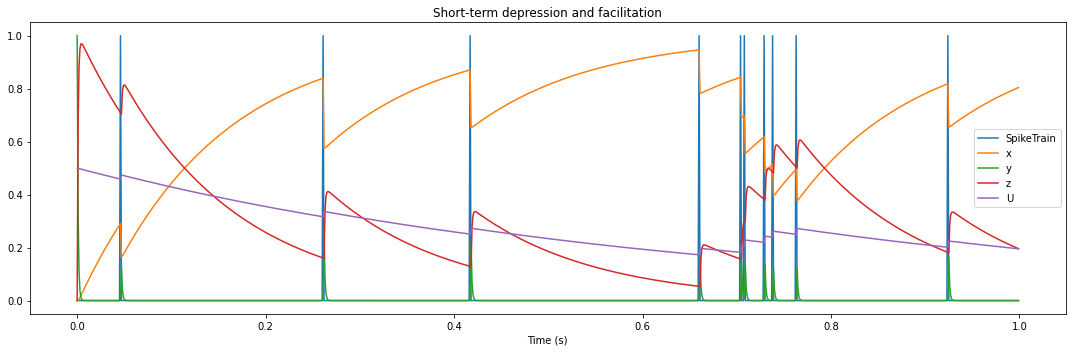

In [55]:
from re import I
# Scenario 2
"""Initialize constants"""
U = 0.5
tau_in = 3
tau_rec = 800

U1 = 0.03
tau_facil = 530
tau_in = 1.5
tau_rec = 130

x, y, z, U = [[0]*1000, [1]*1000, [0]*1000, [U]*1000]
t = np.arange(0,1,0.001)

# Loop over simulation time
for i in range(len(t)-1):
  x[i+1] = x[i] + z[i]/tau_rec - U[i]*x[i]*st[i]
  y[i+1] = y[i] + -y[i]/tau_in + U[i]*x[i]*st[i]
  z[i+1] = z[i] + y[i]/tau_in - z[i]/tau_rec
  U[i+1] = U[i] + -U[i]/tau_facil + U1*(1-U[i])*st[i]

# Plot spike train, x, y, z, and U
fig2 = plt.figure(2, figsize = (15, 5), tight_layout = True)
plt.plot(t, st, label='SpikeTrain')
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.plot(t, z, label='z')
plt.plot(t, U, label='U')
plt.legend()
plt.title('Short-term depression and facilitation')
plt.xlabel("Time (s)")

### 1.2
Generate $N=10$ input spike trains and simulate a leaky integrate and fire neuron driven by these inputs,
* when the synapses are constant (current-based synapses),
* when synapses follow the Tsodyks-Markram model (Scenario 1),
* when synapses follow the Tsodyks-Markram model (Scenario 2).

Choose the synaptic weight parameter $w$ such that the output firing rate is approximately $10Hz$.
Plot the output spike trains in each case.

Output frequency:
10.05


Text(0.5, 0, 'Time, t (ms)')

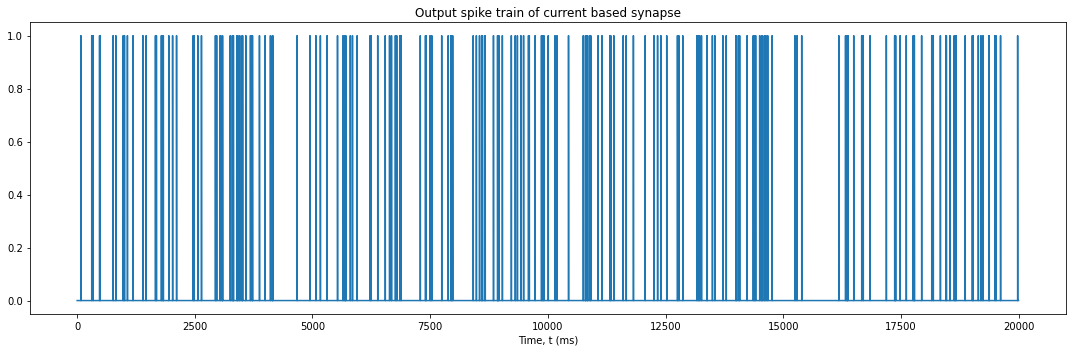

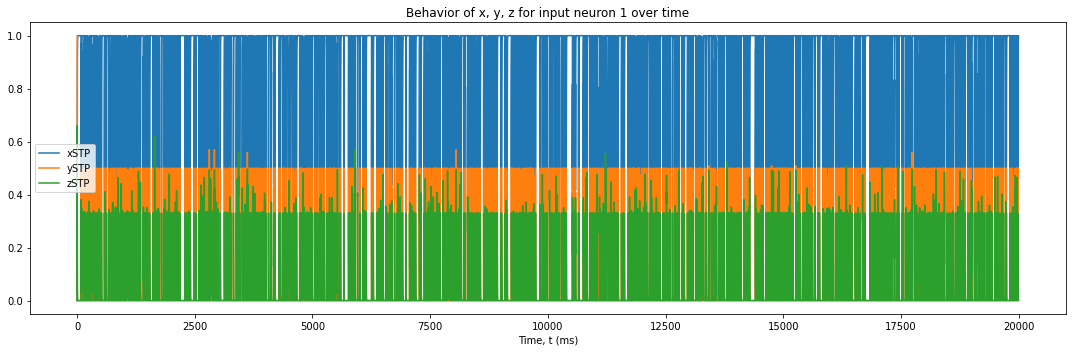

In [56]:
# Scenario 1 (current-based synapses):
Vth   = 1     # LIF Voltage threshold
Vr    = 0     # LIF Voltage reset
tref  = 2     # LIF number of timepoints for refractory period
dt    = 0.1   
T     = 20000 # LIF Total number of timepoints to simulate

t  = np.arange(start=0.0, stop=T, step=dt)
Lt = np.size(t)

N  = 10       # number of input signals to generate
fr = 50       # firing rate of each input neuron

V_out      = np.zeros_like(t)
S_out      = np.zeros_like(t)

S_in       = np.zeros([Lt, N])
xSTP       = np.zeros([Lt, N])
ySTP       = np.ones([Lt, N])
zSTP       = np.zeros([Lt, N])
USTP       = np.zeros([Lt, N])

taurec     = 20
tauin      = 5
USE        = 0.5

# Generate input spike signals
S_in = (random.rand(Lt, N) < fr*dt/1000)*1

# synaptic weight
W = 0.8

tr = 0
for it in range(Lt-1):
    
    # STP update step
    for i in range(N):
        dxdt = (zSTP[it,i]/taurec - USE*xSTP[it, i]*S_in[it, i])/dt
        dydt = (-ySTP[it,i]/tauin + USE*xSTP[it, i]*S_in[it, i])/dt
        dzdt = (ySTP[it,i]/tauin - zSTP[it,i]/taurec)/dt

        xSTP[it+1,i] = xSTP[it,i]+dxdt*dt
        ySTP[it+1,i] = ySTP[it,i]+dydt*dt
        zSTP[it+1,i] = zSTP[it,i]+dzdt*dt
    
    # LIF update step
    if tr > 0:
        V_out[it] = Vr
        tr    = tr-1
    elif V_out[it]>=Vth:
        S_out[it] = 1
        V_out[it] = Vr
        tr = tref/dt
        
    dV = -V_out[it] + W*sum(S_in[it,:])
    V_out[it+1] = V_out[it]+dV

print('Output frequency:')
print(np.sum(S_out)/T*1000)

fig3 = plt.figure(3, figsize = (15, 5), tight_layout = True)
plt.plot(t, S_out)
plt.title('Output spike train of current based synapse')
plt.xlabel("Time, t (ms)")

fig10 = plt.figure(10, figsize = (15, 5), tight_layout = True)
plt.plot(t, xSTP[:, 1], label='xSTP')
plt.plot(t, ySTP[:, 1], label='ySTP')
plt.plot(t, zSTP[:, 1], label='zSTP')
plt.legend()
plt.title('Behavior of x, y, z for input neuron 1 over time')
plt.xlabel("Time, t (ms)")

Output frequency:
8.8


Text(0.5, 0, 'Time, t (ms)')

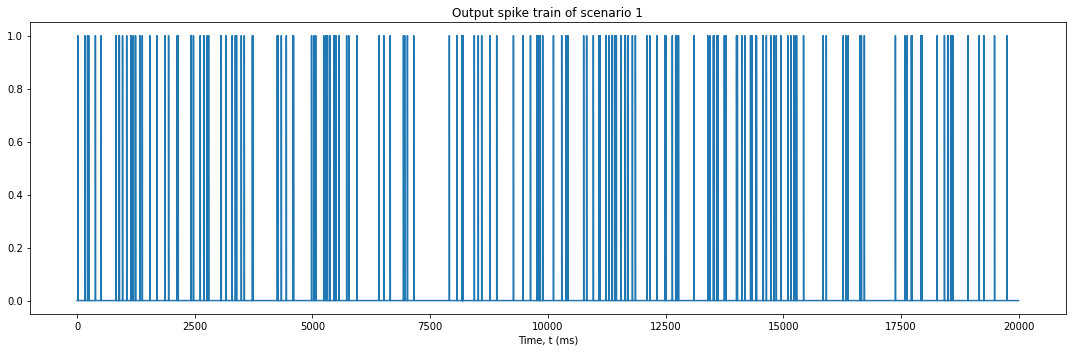

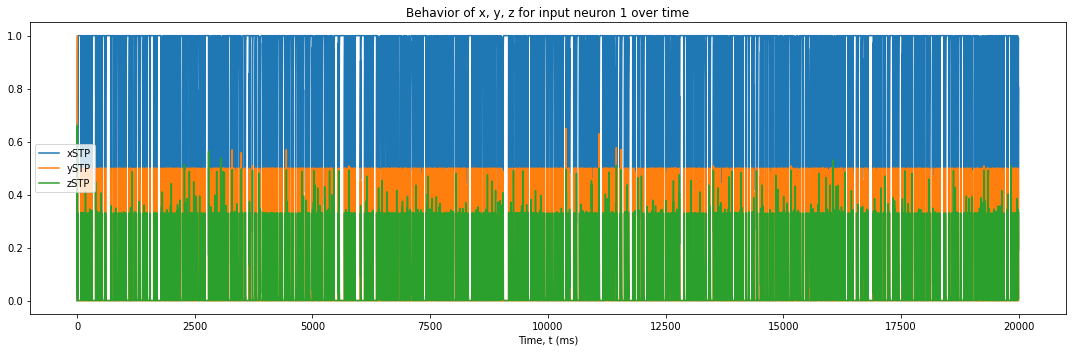

In [57]:
# Scenario 2 (T-M model scenario 1):
Vth   = 1     # LIF Voltage threshold
Vr    = 0     # LIF Voltage reset
tref  = 2     # LIF number of timepoints for refractory period
dt    = 0.1   
T     = 20000 # LIF Total number of timepoints to simulate

t  = np.arange(start=0.0, stop=T, step=dt)
Lt = np.size(t)

N  = 10     # number of input signals to generate
fr = 50     # firing rate of each input neuron

V_out      = np.zeros_like(t)
S_out      = np.zeros_like(t)

S_in       = np.zeros([Lt, N])
xSTP       = np.zeros([Lt, N])
ySTP       = np.ones([Lt, N])
zSTP       = np.zeros([Lt, N])
USTP       = np.zeros([Lt, N])

taurec     = 20
tauin      = 5
USE        = 0.5

# Generate input spike signals
S_in = (random.rand(Lt, N) < fr*dt/1000)*1

# synaptic weight
W = 4

tr = 0
for it in range(Lt-1):
    
    # STP update step
    for i in range(N):
        dxdt = (zSTP[it,i]/taurec - USE*xSTP[it, i]*S_in[it, i])/dt
        dydt = (-ySTP[it,i]/tauin + USE*xSTP[it, i]*S_in[it, i])/dt
        dzdt = (ySTP[it,i]/tauin - zSTP[it,i]/taurec)/dt

        xSTP[it+1,i] = xSTP[it,i]+dxdt*dt
        ySTP[it+1,i] = ySTP[it,i]+dydt*dt
        zSTP[it+1,i] = zSTP[it,i]+dzdt*dt
    
    # LIF update step
    if tr > 0:
        V_out[it] = Vr
        tr    = tr-1
    elif V_out[it]>=Vth:
        S_out[it] = 1
        V_out[it] = Vr
        tr = tref/dt
        
    dV = -V_out[it] + W*sum(np.multiply(ySTP[it,:], S_in[it,:]))
    V_out[it+1] = V_out[it] + dV

print('Output frequency:')
print(np.sum(S_out)/T*1000)

fig4 = plt.figure(4, figsize = (15, 5), tight_layout = True)
plt.plot(t, S_out)
plt.title('Output spike train of scenario 1')
plt.xlabel("Time, t (ms)")

fig11 = plt.figure(11, figsize = (15, 5), tight_layout = True)
plt.plot(t, xSTP[:, 1], label='xSTP')
plt.plot(t, ySTP[:, 1], label='ySTP')
plt.plot(t, zSTP[:, 1], label='zSTP')
plt.legend()
plt.title('Behavior of x, y, z for input neuron 1 over time')
plt.xlabel("Time, t (ms)")

Output frequency:
8.55


Text(0.5, 0, 'Time, t (ms)')

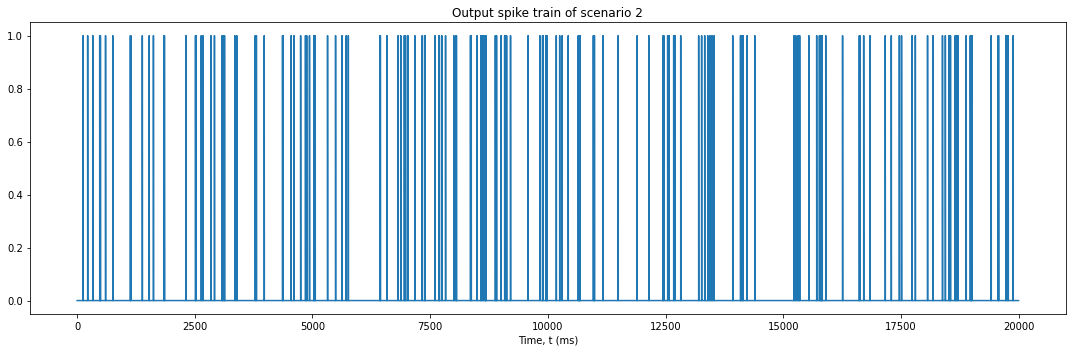

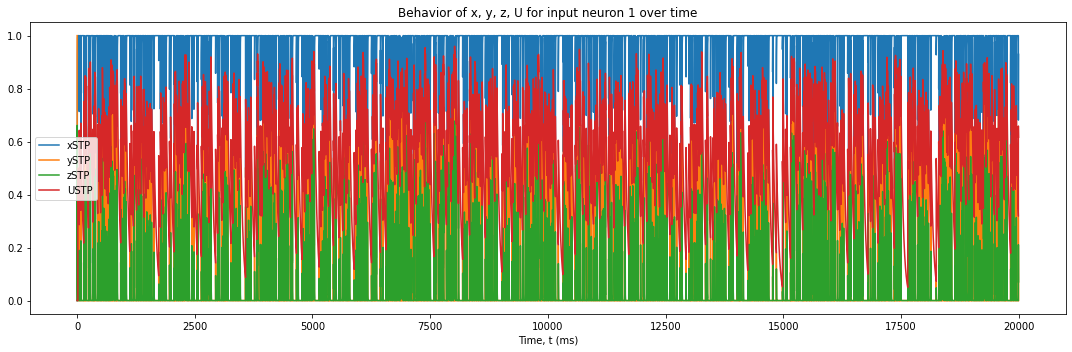

In [58]:
# Scenario 3 (T-M model scenario 2):
Vth   = 1     # LIF Voltage threshold
Vr    = 0     # LIF Voltage reset
tref  = 2     # LIF number of timepoints for refractory period
dt    = 0.1   
T     = 20000 # LIF Total number of timepoints to simulate

t  = np.arange(start=0.0, stop=T, step=dt)
Lt = np.size(t)

N  = 10     # number of input signals to generate
fr = 50     # firing rate of each input neuron

V_out      = np.zeros_like(t)
S_out      = np.zeros_like(t)

S_in       = np.zeros([Lt, N])
xSTP       = np.zeros([Lt, N])
ySTP       = np.ones([Lt, N])
zSTP       = np.zeros([Lt, N])
USTP       = np.zeros([Lt, N])

taurec     = 20
tauin      = 5
USE        = 0.5

# Generate input spike signals
S_in = (random.rand(Lt, N) < fr*dt/1000)*1

# synaptic weight
W = 4

tr = 0
for it in range(Lt-1):
    
    # STP update step
    for i in range(N):
        dxdt = (zSTP[it,i]/taurec - USTP[it, i]*xSTP[it, i]*S_in[it, i])/dt
        dydt = (-ySTP[it,i]/tauin + USTP[it, i]*xSTP[it, i]*S_in[it, i])/dt
        dzdt = (ySTP[it,i]/tauin - zSTP[it, i]/taurec)/dt
        dUdt = (-USTP[it,i]/tau_facil + USE*(1-USTP[it, i])*S_in[it, i])/dt

        xSTP[it+1,i] = xSTP[it,i]+dxdt*dt
        ySTP[it+1,i] = ySTP[it,i]+dydt*dt
        zSTP[it+1,i] = zSTP[it,i]+dzdt*dt
        USTP[it+1,i] = USTP[it,i]+dUdt*dt
    
    # LIF update step
    if tr > 0:
        V_out[it] = Vr
        tr    = tr-1
    elif V_out[it]>=Vth:
        S_out[it] = 1
        V_out[it] = Vr
        tr = tref/dt
        
    dV = -V_out[it] + W*sum(np.multiply(ySTP[it,:], S_in[it,:]))
    V_out[it+1] = V_out[it] + dV

print('Output frequency:')
print(np.sum(S_out)/T*1000)

fig5 = plt.figure(5, figsize = (15, 5), tight_layout = True)
plt.figure(5)
plt.plot(t, S_out)
plt.title('Output spike train of scenario 2')
plt.xlabel("Time, t (ms)")

fig12 = plt.figure(12, figsize = (15, 5), tight_layout = True)
plt.plot(t, xSTP[:, 1], label='xSTP')
plt.plot(t, ySTP[:, 1], label='ySTP')
plt.plot(t, zSTP[:, 1], label='zSTP')
plt.plot(t, USTP[:, 1], label='USTP')
plt.legend()
plt.title('Behavior of x, y, z, U for input neuron 1 over time')
plt.xlabel("Time, t (ms)")

### 1.3
Can you determine based on the output spike-train whether the synapses are constant / short-term depression (Scenario 1) / short-term facilitation and depression (Scenario 2)?

If yes, what properties of the spike train can you use to determine which synapse model was used?

If not, how would you change the parameters of the simulation so that different synapse models will lead to output spike trains that can be distinguished?

---
Hints:

* How does the relative contribution of each input depend on the total number of inputs N? 

* What is the ﬁring rate of each input relative to the diﬀerent timescales, and speciﬁcally the recovery and facilitation timescales?

* Is the output ﬁring rate constant in each scenario?

* Does the inter-spike-interval distribution tell us anything about the synaptic dynamics?

---

# Written answer

From only a single output spike train the information that can be extracted is limited, but several cues can be used to tell the synaptic model being used: in a constant synapse, a relatively uniform spike train should be observed; in scenario 1 of the T-M synapse, short-term depression can be found, but not facilitation; in scenario 2, both may be seen. That is, we can use the inter-spike-interval to determine whether short-term plasticity has taken place. However, the observation cannot be used to reliably identify the synaptic model because the input spike train is Poisson distributed. When a certain number of random input spikes coincide within a specific time window, facilitation or depression would occur, but the process occurs randomly given the random input spikes. I think one way to control is to manually design the input spike trains to determine exactly what patterns may lead to certain STP.

The relative contribution of each input would decrease as the total number of inputs increases. The larger the tau recovery is, the lower input rate is required to lead to depression; the smaller the tau facilitation is, the higher input rate would be required to cause facilitation.


# Q2
Suppose a neuron has the following f-I curve for different levels of input noise ($f$ is measured in $Hz$):

$$
f_{\sigma}(I)= \begin{cases}\sigma & I<1 \\ \sigma+\sqrt{I-1} & I \geq 1\end{cases}
$$

Recall the self-consistency equation we derived in class for the output of a neuron in an all-to-all network with weak synapses (synaptic weight$ = w/N$, which implies $\sigma=0$).

$$\phi = f_0(w\phi)$$

* Plot the firing rate $\phi$ as a function of the synaptic weight parameter $w$ which solves this equation.

  What is the minimum synaptic weight required for activity in the network?

* When synapses in the network undergo short-term depression, we found a modified version of this self-consistency equation
$$
\phi=f_{0}(w \phi\langle y\rangle)
$$
where $\langle y \rangle$ is the average amount of synaptic resources in the network
$$
\langle y\rangle=\tau_{\text {in }} U\langle x\rangle \phi.
$$
  We also derived an equation for the average amount of recovered resources
$$
\frac{\mathrm{d}\langle x\rangle}{\mathrm{d} t}=\frac{1-\langle x\rangle}{\tau_{\text {rec }}}-U\langle x\rangle \phi.
$$
For the parameters of Scenario 1 in Q1, what are the steady state values of $\langle x \rangle$ and $\langle y \rangle$ as a function of $\phi$?

Text(0, 0.5, 'firing rate (Hz)')

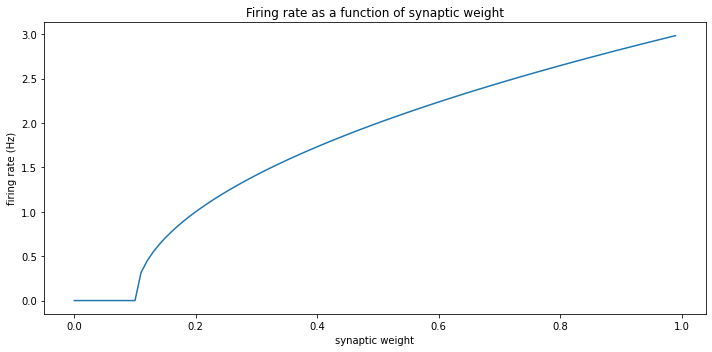

In [59]:
# Initialize parameters
w = np.arange(0,1,0.01)
phi = np.ones(np.size(w))*10 # Initialize the network with 10 Hz firing rate

# Model
def fr(weight, firingRate):
  if(weight*firingRate < 1):
    return 0
  else:
    return 0 + np.sqrt(weight*firingRate - 1)

for i in range(np.size(phi)):
  phi[i] = fr(w[i], phi[i])

# Plot the firing rate 𝜙 as a function of the synaptic weight parameter 𝑤 which solves this equation
fig6 = plt.figure(6, figsize = (10, 5), tight_layout = True)
plt.figure(6)
plt.plot(w, phi)
plt.title('Firing rate as a function of synaptic weight')
plt.xlabel("synaptic weight")
plt.ylabel("firing rate (Hz)")

# Written answer

For a initial firing rate of 10 Hz in the network, the minimum synaptic weight required for maintainig activity is 0.1.

For the given parameters, the approximate steady state values for <x> and <y> are:
0.010101010101010102 and 0.25


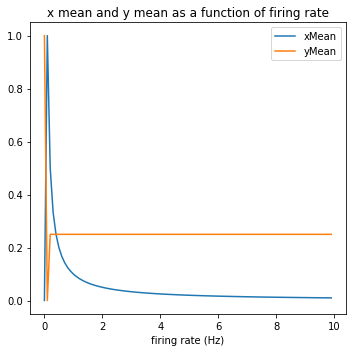

In [60]:
# All-to-all network with parameters from T-M model scenario 1:
# Initialize parameters
Vth   = 1     # LIF Voltage threshold
Vr    = 0     # LIF Voltage reset
tref  = 2     # LIF number of timepoints for refractory period
dt    = 0.1   
T     = 20000 # LIF Total number of timepoints to simulate

t  = np.arange(start=0.0, stop=T, step=dt)
Lt = np.size(t)

N  = 10     # number of input signals to generate
fr = 10     # firing rate of each input neuron

'''
V_out      = np.zeros_like(t)
S_out      = np.zeros_like(t)

S_in       = np.zeros([Lt, N])
xSTP       = np.zeros([Lt, N])
ySTP       = np.ones([Lt, N])
zSTP       = np.zeros([Lt, N])
USTP       = np.zeros([Lt, N])
'''

taurec     = 20
tauin      = 5
USE        = 0.5

# All-to-all parameters
phi = np.arange(0,10,0.1)
xmean = np.zeros(np.size(phi))
ymean = np.ones(np.size(phi))

# synaptic weight
W = 0.5

# Model
for i in range(np.size(phi)-1):
  ymean[i+1] = tauin*USE*xmean[i]*phi[i]
  xmean[i+1] = 1/(USE*phi[i]*taurec+1) # Setting dxdt to 0

# Plot to find steady state values of xmean and ymean as a function of phi
fig7 = plt.figure(7, figsize = (5, 5), tight_layout = True)
plt.figure(7)
plt.plot(phi, xmean, label='xMean')
plt.plot(phi, ymean, label='yMean')
plt.legend()
plt.title('x mean and y mean as a function of firing rate')
plt.xlabel("firing rate (Hz)")

# Print steady state values
print('For the given parameters, the approximate steady state values for <x> and <y> are:')
print(str(xmean[-1]) + ' and ' + str(ymean[-1]))

# Written answer

The steady state values of \<x\> and \<y\> are found by setting dx/dt and dy/dt to 0. Doing so we get: $\langle y \rangle = \tau_{in}*U*\langle x \rangle*\phi$, and $\langle x \rangle = \frac{1}{U*\phi*\tau_{rec} + 1}$, both being a function of U and phi. Assuming constant U, their steady states can be found by infinitely increasing firing rate $\phi$

* How does the short term depression affect the minimal synaptic weight needed for activity in the network?

---
Hint: Substitute $\langle y \rangle$ with the relationship you found into the modiﬁed self-consistency equation, and solve it numerically. Note that a short inactivation timescale $\tau_{\rm in}$ implies that $\langle y \rangle$ is small, as discussed in class. This means that the relevant range of $w$ values might be different compared to the case with no short term depression.

---

# Written answer

For the neuronal population with the given $f_{\sigma}(I)$ and a specific firing rate $\phi$, if the $\tau_{in}$ is small, then $\langle y \rangle$ is small, and the synaptic weight required for activity would be large; if the $\tau_{in}$ is large, then $\langle y \rangle$ is large, and the synaptic weight required for activity would be smaller.

# Q3
### 3.0
* Generate a random adjacency matrix for a network with $N=500$ neurons, connectivity parameter $p=0.1$, and no self connections ($A_{ii}=0$)

* Plot the in-degree and out-degree distributions. Do they agree with the formula we found in class?





[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]


Text(0.5, 0, 'Out degree')

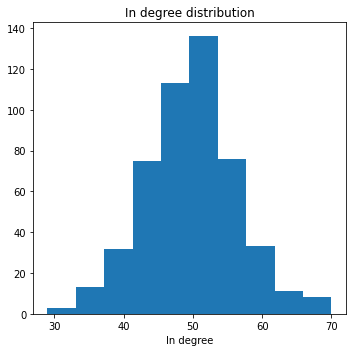

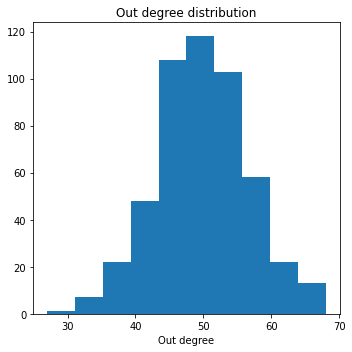

In [61]:
# sample code to generate a random adjacency matrix
n = 500   # number of nodes
p = 0.1   # probability of a connection
adj = np.zeros((n, n), dtype=int)
directed = True

if directed:
  edges = itertools.permutations(range(n), 2)
else:
  edges = itertools.combinations(range(n), 2)

for e in edges: # for each possible edge
  if e[0] == e[1]: # skip self connections
    continue
  if np.random.rand() < p: 
    adj[e[0], e[1]] = 1     # make a connection for this edge
print(adj)

# Plot in-degree distribution
ind = np.sum(adj, axis=0)
fig8 = plt.figure(8, figsize = (5, 5), tight_layout = True)
plt.figure(8)
plt.hist(ind)
plt.title('In degree distribution')
plt.xlabel('In degree')

# Plot out-degree distribution
outd = np.sum(adj, axis=1)
fig9 = plt.figure(9, figsize = (5, 5), tight_layout = True)
plt.figure(9)
plt.hist(outd)
plt.title('Out degree distribution')
plt.xlabel('Out degree')

### 3.1
* Choose 2 of the 13 possible 3-neuron motifs and compute the probability of their appearance in the network.

  Hint: you can loop over all the neurons in the network 3 times, and based on $A_{ij}, A_{ji}, A_{jk}, A_{kj}, A_{ki}, A_{ik}$ determine if each neuron triplet has a motif or not.

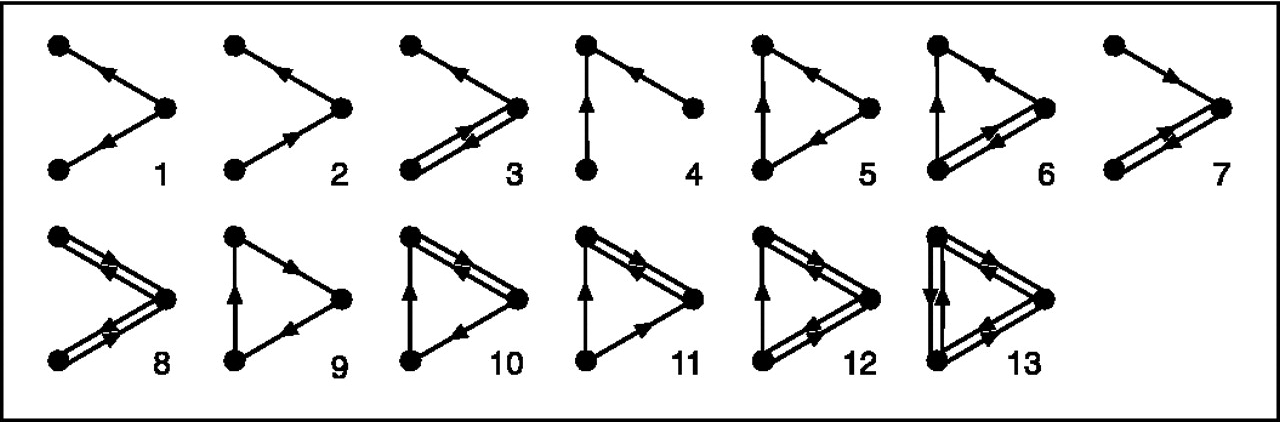

In [62]:
# For motifs 2 and 3
'''
from itertools import permutations

threeNeuronsPerm = permutations(range(n), 3)
for threeNeurons in list(threeNeuronsPerm):
  i, j, k = threeNeurons
  print(threeNeurons)
'''

nmotif2 = 0
nmotif3 = 0

for i in range(n):
  for j in range(n):
    for k in range(n):
      if i != j and j != k and k != i:
        if adj[i,j] == adj[j,k] == 1 and adj[k,i] == adj[i,k] == adj[k,j] == adj[j,i] == 0:
          nmotif2 = nmotif2 + 1
        elif adj[i,j] == adj[j,k] == adj[k,j] == 1 and adj[k,i] == adj[i,k] == adj[j,i] == 0:
          nmotif3 = nmotif3 + 1

nmotif2 = nmotif2*2 # Account for the reverse direction
nmotif3 = nmotif3*2

pmotif2 = nmotif2/(500**3 - 500*3)
pmotif3 = nmotif3/(500**3 - 500*3)

print('probability of motif 2 is: ' + str(pmotif2))
print('probability of motif 3 is: ' + str(pmotif3))

probability of motif 2 is: 0.013157933895206742
probability of motif 3 is: 0.0013625123501482019


Compare the probabilities of the motifs to what you would expect based on the calcluation done in class for the loop motif (motif 9).



# Written answer

The probability of motif 9 (loop) is $2*p^3(1-p^3)$. For the given $p = 0.1$, the probability would be 0.001458. This is similar to the probability of motif 3, because both require 3 specific connections. Motif 2 has a higher probability because it only requires 2 connections.

---
### 3.2
We provide here the connectivity matrices for the fruit-ﬂy, for two subnetworks in that animal’s brain involved in olfactory processing: The antennal-lobe (AL) and mushroom-body (MB) network, and the antennal-lobe (AL) and lateral-horn (LH) network.

- Compute the overall average degree of connectivity for each network.

- Compute the in-degree and out-degree distributions. Are they the same? Are they correlated?

- Do they agree of the prediction of the random network based on the global connectivity parameter you computed.

- Based on your results, discuss diﬀerences between AL to MB connections and AL to LH connections.

- Bonus: Suggest and implement a scheme for generating a network that has the same degree distribution as the ﬂy connectome, but is otherwise random.

To be able to work on these files within Google Colab, you need to upload them each time you start a new session.

You can do so by navigating to the folder icon on the left side and then upload the 2 .csv files.
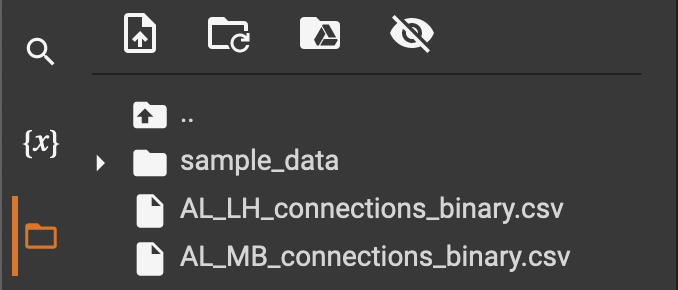

In [63]:
# example code to load .csv files
from pandas import read_csv
# The data will be read into a Pandas DataFrame object.
AL_LH = read_csv('/content/AL_LH_connections_binary-1.csv')
AL_MB = read_csv('/content/AL_MB_connections_binary.csv')

# The data can then be accessed by using .values
AdjAL_LH = AL_LH.values[:,1:] # skip the first column of names
AdjAL_MB = AL_MB.values[:,1:] # skip the first column of names
print(AdjAL_LH)
print(AdjAL_MB)

[[1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 1 1]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


Average in-degree of AL-LH network is: 116.80757420675538
Average out-degree of AL-LH network is: 116.80757420675538
Average in-degree of AL-MB network is: 71.33070866141732
Average out-degree of AL-MB network is: 58.824675324675326


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 0, 'degree of connectivity')

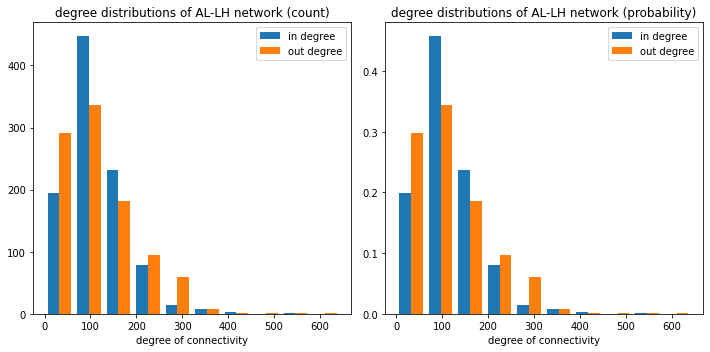

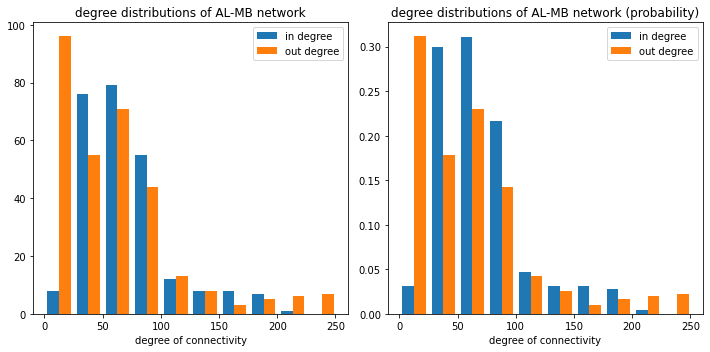

In [64]:
## Degree of connectivity
# In- and out-degrees of AL-LH network
indAL_LH = np.sum(AdjAL_LH, axis=0)
outdAL_LH = np.sum(AdjAL_LH, axis=1)

# Average degrees of connectivity of AL-LH network
meanIndAL_LH = indAL_LH.mean()
print('Average in-degree of AL-LH network is: ' + str(meanIndAL_LH))
meanOutdAL_LH = outdAL_LH.mean()
print('Average out-degree of AL-LH network is: ' + str(meanOutdAL_LH))

# In- and out-degrees of AL-MB network
indAL_MB = np.sum(AdjAL_MB, axis=0)
outdAL_MB = np.sum(AdjAL_MB, axis=1)

# Average degrees of connectivity of AL-MB network
meanIndAL_MB = indAL_MB.mean()
print('Average in-degree of AL-MB network is: ' + str(meanIndAL_MB))
meanOutdAL_MB = outdAL_MB.mean()
print('Average out-degree of AL-MB network is: ' + str(meanOutdAL_MB))

## Degree distributions
# Degree distributions of AL-LH network
fig13 = plt.figure(13, figsize = (10, 5), tight_layout = True)
plt.figure(13)
plt.subplot(121)
plt.hist([indAL_LH, outdAL_LH], label=['in degree', 'out degree'])
plt.legend()
plt.title('degree distributions of AL-LH network (count)')
plt.xlabel('degree of connectivity')

plt.subplot(122)
plt.hist([indAL_LH, outdAL_LH], weights=[np.ones(len(indAL_LH))/len(indAL_LH), np.ones(len(outdAL_LH))/len(outdAL_LH)], label=['in degree', 'out degree'])
plt.legend()
plt.title('degree distributions of AL-LH network (probability)')
plt.xlabel('degree of connectivity')

# Degree distributions of AL-MB network
fig14 = plt.figure(14, figsize = (10, 5), tight_layout = True)
plt.figure(14)
plt.subplot(121)
plt.hist([indAL_MB, outdAL_MB], label=['in degree', 'out degree'])
plt.legend()
plt.title('degree distributions of AL-MB network')
plt.xlabel('degree of connectivity')

plt.subplot(122)
plt.hist([indAL_MB, outdAL_MB], weights=[np.ones(len(indAL_MB))/len(indAL_MB), np.ones(len(outdAL_MB))/len(outdAL_MB)], label=['in degree', 'out degree'])
plt.legend()
plt.title('degree distributions of AL-MB network (probability)')
plt.xlabel('degree of connectivity')

# Written answer

The AL-LH network has a higher in-degree then out degree, whereas the AL-MB network has a higher out-degree. The in- and out-degrees are somewhat correlated as they are distributed in approximately the same shape. All 4 of the degree distributions agree with the computed average degrees of connectivity.

In [65]:
print(np.shape(AdjAL_LH))
print(np.shape(AdjAL_MB))
print(np.sum(AdjAL_LH)/(np.size(AdjAL_LH))*np.shape(AdjAL_LH)[0])
print(np.sum(AdjAL_LH)/(np.size(AdjAL_LH))*np.shape(AdjAL_LH)[1])
print(np.sum(AdjAL_MB)/(np.size(AdjAL_MB))*np.shape(AdjAL_MB)[0])
print(np.sum(AdjAL_MB)/(np.size(AdjAL_MB))*np.shape(AdjAL_MB)[1])

(977, 977)
(308, 254)
116.80757420675536
116.80757420675536
71.33070866141733
58.824675324675326


The AL-LH data is a square matrix, approximating a random network. Its average in- and out-degrees correspond to the value given by $\langle K \rangle = Np$ for a random network, where p is the calculated probability of connection.

The AL-MB data, however, has different values in its axes and therefore different average in- and out-degrees.

Generally, the AL-LH network has a higher overall degree of connectivity, meaning its connections are denser than those in the AL-MB network.